In [13]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import numpy as np
from matplotlib import pyplot as plt
from helper_functions import accuracy_fn

def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
    """Performs a training with model trying to learn on data_loader"""
    train_loss, train_acc = 0, 0

    model.to(device)

    model.train()
    for X, y in data_loader:    
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f}%")


def test_step(model, data_loader, loss_fn, accuracy_fn, device):
    """Performs a training with model trying to learn on data_loader"""
    test_loss, test_acc = 0, 0

    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}%")

def eval_model(model: torch.nn.Module, data_loader, loss_fn, accuracy_fn):
    """
    Returns a dictionary containing the results of model predicting on data_loader
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            y_pred = model(X)

            # accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)


    return {"model_name": model.__class__.__name__, "loss": loss.item(), "accuracy": acc}

# Convolutional Neural Network (CNN)

Una CNN es un tipo de red neuronal especialmente diseñada para procesar datos que tienen una estructura de rejilla, como imágenes o señales de audio. Se utilizan ampliamente en tareas de visión por computadora, reconocimiento de imágenes, procesamiento de video y más.

La clave de una CNN son las capas convolucionales. Estas capas aplican filtros (kernels) a la entrada, realizando operaciones de convolución. Esto permite que la red pueda aprender características importantes de las imágenes, como bordes, texturas o patrones más complejos. Además de las capas convolucionales, las CNN también suelen incluir capas de agrupación (pooling) que reducen la dimensionalidad de las características extraídas, y capas completamente conectadas al final para realizar la clasificación final.

Una ventaja importante de las CNN es su capacidad para aprender representaciones jerárquicas de características. En las primeras capas, la red puede aprender características simples como bordes y colores, mientras que en las capas más profundas puede combinar estas características simples para reconocer objetos más complejos y abstractos.

## Convolución sobre una imagen

Al convolucionar una imagen se produce una imagen nueva (a la cual llamamos mapa de características), donde cada pixel es resultado de aplicar un filtro (matriz de numeros, o kernel) sobre la imagen de entrada y se multiplicar y sumar los valores de pixeles vecinos. El resultado de la nueva imagen dependera de los valores del kernel.

Si tenemos por ejemplo un filtro de la siguiente manera:

\begin{equation}
    \begin{pmatrix}
    0 & 0 & 0\\
    0 & 1 & 0\\
    0 & 0 & 0
    \end{pmatrix}
\end{equation}

el resultado será una copia exacta de la misma imagen, ya que en este caso el pixel de la imagen será $1 \cdot$ valor de pixel central + $ 0 \cdot$ valores de pixeles vecinos. En cambio si aplicamos  un filtro de esta otra manera:

\begin{equation}
    \begin{pmatrix}
    1 & 1 & 1\\
    1 & 1 & 1\\
    1 & 1 & 1
    \end{pmatrix}
\end{equation}

y luego divimos entre el numero de pixeles, estaremos calculando la media de ellos y como resultado tendríamos un efecto de desenfoque en la imagen. También podemos obtener una diferencia de contrastes para detectar bordes con:

\begin{equation}
    \begin{pmatrix}
    -1 & 0 & 1\\
    -1 & 0 & 1\\
    -1 & 0 & 1
    \end{pmatrix}
\end{equation}

En resumen, estos filtros se utilizan para buscar patrones en las imagenes y la red neuronal se encarga de buscar los valores para dichos filtros por sí misma.

In [2]:
torch.manual_seed(42)

#toy data
images = torch.randn(32, 3, 64, 64)
test_image = images[0]

conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, stride=2, padding=0)

#### Hiperparámetros de una red convolucional
- Kernel_size: tamaño del filtro
- Stride: Cada cuantos pixeles ocurre la convolución. Se comprime la salida
- Padding: El kernel opera sobre los bordes para detectar patrones

Una capa convolucional termina comprimiendo la entrada en un tipo de representation

In [3]:
conv_output = conv_layer(test_image)

#en algunas versiones de pytorch es necesario hacer .unsqueeze(0)

conv_output

tensor([[[-0.1129,  0.5471, -0.5891,  ..., -0.5712,  0.4182, -0.5001],
         [ 1.4239,  0.7090, -0.6610,  ...,  0.1041,  1.0934,  0.7875],
         [ 0.1732,  0.4402,  0.1813,  ..., -0.1690,  0.7322,  0.3567],
         ...,
         [-0.8742, -0.1147, -0.6988,  ...,  0.7947, -0.4199, -0.3224],
         [-1.0841, -0.1257,  0.0860,  ...,  0.3970,  0.6671,  0.0722],
         [ 0.0717,  0.0461, -0.2053,  ..., -0.4966,  0.5335,  0.0132]],

        [[-0.8464,  0.6344, -0.9584,  ..., -0.1285, -0.6308, -0.1071],
         [-0.5381,  0.4864, -0.1222,  ..., -0.1194,  0.3768,  0.0826],
         [-0.7345,  0.8163, -0.1800,  ..., -1.1557, -0.3832,  0.7655],
         ...,
         [-0.7267, -0.3499,  0.1426,  ...,  0.0694,  0.6739,  0.1269],
         [-0.2240,  0.3323,  0.1510,  ...,  0.0349,  0.2731, -0.5165],
         [ 0.0749, -0.7949,  0.3974,  ...,  0.8010, -0.1916, -0.1639]],

        [[-1.1718, -0.3714, -0.4953,  ..., -0.1188, -0.3608, -0.0154],
         [-0.5746, -0.7343, -0.3105,  ..., -0

---------------------------------------------

In [4]:
device = "cpu"

#Get data

train_data = datasets.FashionMNIST(root="data", train = True, download=False, transform = torchvision.transforms.ToTensor(), target_transform=None)
test_data = datasets.FashionMNIST(root="data", train = False, download=False, transform = torchvision.transforms.ToTensor(), target_transform=None)

class_names, class_to_idx = train_data.classes, train_data.class_to_idx

image, label= train_data[0]

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

## Construcción de una CNN

La potencia de una CNN radica en combinar multiples capas convolucionales en donde se detecten patrones cada vez más complejos.

MaxPooling lo que hace es comprimir los datos, la salida es la mitad del tamaño de la entrada. De esta forma, a medida que los datos van pasando a través del modelo, estos se van haciendo más chicos. En cada capa va aprendiendo representaciones más comprimidas 

In [5]:
class FashionMNISTModelV2(nn.Module):
    """Model architecture that replicates the TinyVGG model from CNN explainer websute
        If the design_mode param is true, every time the forward method executes the model with show x.shape after each block
    """
    def __init__(self, input_shape, hidden_units, output_shape, design_mode):
        super().__init__()

        self.design_mode = design_mode

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)  #acá hay que calcular con qué forma llega el tensor de entrada
        )

    def toggle_design_mode(self):
        self.design_mode = not(self.design_mode)

    def forward(self, x):
        x = self.conv_block_1(x)
        if self.design_mode: print(f"Output of conv block 1: {x.shape}")
        x = self.conv_block_2(x)
        if self.design_mode: print(f"Output of conv block 2: {x.shape}")
        x =  self.classifier(x)
        if self.design_mode: print(f"Output of classifier block: {x.shape}")
        return x

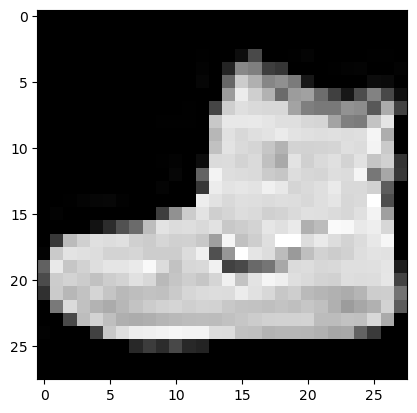

In [6]:
plt.imshow(image.squeeze(), cmap="grey")

In [7]:
image.shape

torch.Size([1, 28, 28])

En nuestro caso tenemos solo un canal de colores (B&W)

In [8]:
torch.manual_seed(42)

rand_img_tensor = torch.randn(size = (1, 28, 28))

model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names), design_mode=True).to(device)

In [9]:
rand_img_tensor = torch.randn(size=(1, 28, 28))
model_2(rand_img_tensor.unsqueeze(0))

Output of conv block 1: torch.Size([1, 10, 14, 14])
Output of conv block 2: torch.Size([1, 10, 7, 7])
Output of classifier block: torch.Size([1, 10])


tensor([[-0.0339, -0.0266,  0.0560,  0.0843, -0.0039, -0.0867,  0.0439, -0.0262,
         -0.0898, -0.0353]], grad_fn=<AddmmBackward0>)

In [10]:
if model_2.design_mode:
    model_2.toggle_design_mode()

## Loss Function, Optimizer y training loop

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.1)

In [12]:
torch.manual_seed(42)

epochs = 3

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n --------")
    train_step(model=model_2, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn, data_loader=train_dataloader, device="cpu")
    test_step(model=model_2, loss_fn=loss_fn, accuracy_fn=accuracy_fn, data_loader=test_dataloader, device="cpu")

Epoch: 0
 --------
Train loss: 0.59047 | Train accuracy: 78.54500%
Test loss: 0.39039 | Test accuracy: 85.90256%
Epoch: 1
 --------
Train loss: 0.35098 | Train accuracy: 87.36167%
Test loss: 0.33215 | Test accuracy: 87.94928%
Epoch: 2
 --------
Train loss: 0.31197 | Train accuracy: 88.69167%
Test loss: 0.32331 | Test accuracy: 88.21885%


In [16]:
model_2_results = eval_model(model=model_2, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'loss': 0.32331225275993347,
 'accuracy': 88.21884984025559}

## Guardar Modelo

In [17]:
from pathlib import Path

# 1) Crear el directorio
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2) Crear al path de guardado
MODEL_NAME = "03_CNN_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME


# 3) Guardar el model state dict
print(F"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\03_CNN_model_2.pth
